# Hyperparameter Tuning

## alLLM Model architecture choice:
- Token embedding layer
- Transformer blocks
    - Normalization layer
    - Casual self-attention (using RoPE for positional embeddings)
    - Dropout (following attention output)
    - Residual with input to transformer block
    - Normalization layer
    - FFN
        - Linear Layer (expands 4x the hidden size)
        - SwiGLU
        - Dropout (within FFN, after activation)
        - Linear Layer (educes back to hidden size)
    - Residual connection following previous residual output
- Normalization Layer
- Liner Layer (weight sharing with Token embedding layer)

Pre-training dataset: 10BT (with gpt2 tokenizer, which is the same as r50k_base)

## Models with less than 1B parameters with similar architecture
Following the advice of the [Deep Learning Tuning Playbook](https://github.com/google-research/tuning_playbook), let's look at the model and training parameters of similar models.


### [Llama 3.2 (1B)](https://huggingface.co/meta-llama/Llama-3.2-1B)
- Main diff is that it uses grouped-query attention, but that seems to be a memory-footprint optimization for larger models, so for the model here let's not worry about that.
- It uses RoPE (though with more complex frequency setup), SwiGLU, and RMSNorm, same as alLLM.
- It does not use Dropout, as it expects its param size, training dataset size and other optimization to take care of generalization without overfitting.

```python
# Model Params
hParams = HParams(
    n_vocab = 128_256,  # Vocab size
    n_ctx = 131_000,  # Token context length
    n_embd = 2_048,  # Token embedding dimension
    n_head = 32,  # Shares some heads
    n_layer = 16,  # number of attention blocks
    # ffn_act_pdrop -- no dropout
    # attn_res_pdrop -- no dropout
)
hidden layer dimension = n_embd * 4 = 8_192.
# Training Params
Not much public info. 9 trillion tokens used in pre-training, knowledge distillation was used (from 3.1 models), ...
```

### GPT-3 (Small, Medium, Large)
- [Paper](https://arxiv.org/pdf/2005.14165) and old [GPT-2 inference code](https://github.com/openai/gpt-2)
- From a high-level, compared to alLLM, GPT-3 doesn't use RoPE, SwiGLU, RMSNorm, or dropout.
- Trained of 300B tokens.
```python
# Model Params
hParams = 
HParams(       125M  |  350M  |  760M
    n_vocab = 50_257   50_257   50_257
    n_ctx =    2_048    2_048    2_048
    n_embd =     768    1_024    1_536
    n_head =      12       16       16
    n_layer =     12       24       24
    # ffn_act_pdrop -- no dropout
    # attn_res_pdrop -- no dropout
)
hidden layer dimension = n_embd * 4
# Training Params
tParams = 
TParams(                125M  |  350M  |  760M  
    token_batch_size =   0.5M    0.5M     0.5M
    max_lr =             6e-4    3e-4   2.5e-4
    Adam beta 1 =         0.9     0.9      0.9
    Adam beta 2 =        0.95    0.95     0.95
    epsilon =            1e-8    1e-8     1e-8
    clip_grad_max_norm =  1.0     1.0      1.0  # clip global norm of the gradient at 1.0
    weight_decay_rate =   0.1     0.1      0.1
)
AdamW Optimizer.
Warmup + cosine decay LR scheduler:
- There is a linear LR warmup over the first 375 million tokens, from ~0 to max_lr.
- Then there's a cosine decay to 10% of the max_lr value (over 260 billion tokens).
- Then training continues with 10% of max_lr.
```

### OLMo 1B
- [Paper](https://arxiv.org/pdf/2402.00838) and [pre-training code](https://github.com/allenai/OLMo/blob/main/configs/official/OLMo-1B.yaml)
- Like alLLM, OLMo uses weight-tying, RoPE, SwiGLU. Doesn't use dropout or RMSNorm.
- Trained on 2T tokens (using Dolma dataset, which has 2.668T tokens when these models were trained).
```python
# Model Params
hParams = 
HParams(
    n_vocab = 50_280
    n_ctx =    2_048
    n_embd =   2_048
    n_head =      16
    n_layer =     16
    # ffn_act_pdrop -- no dropout
    # attn_res_pdrop -- no dropout
)
hidden layer dimension = n_embd * 8 = 16_384
# Training Params
tParams = 
TParams(
    token_batch_size =    ~4M
    max_lr =             4e-4
    alpha_f =             0.1
    Adam beta 1 =         0.9
    Adam beta 2 =        0.95
    epsilon =            1e-5
    clip_grad_max_norm =  1.0
    weight_decay_rate =   0.1
)
AdamW Optimizer.
Warmup + linear decay LR scheduler:
- Linear warm up over ~21B tokens.
- Then decay linearly to 10% max_lr, reaching that at the end of training.
- Gradient clipping happens after warm-up period.
```


### LLM Foundry MPT (125M, 350M, 760M)
- [Pre-Training code](https://github.com/mosaicml/llm-foundry/tree/main/scripts/train/yamls/pretrain)
- Note that actual pre-train versions of these configs don't officially exist from Databricks, but it's still worth taking a look at.
- MPT 7B was trained with 1T tokens.
- Looking at the [pre-training code in HF for MPT 7B](https://huggingface.co/mosaicml/mpt-7b/tree/main), it seems to use RoPE and MHA. It's likely using GELU, LayerNorm, and weight-tying as well. (A deeper look at code + configs would be needed to be super sure as there's a lot going on in this code base.)

```python
# Model Params
hParams = 
HParams(       125M  |  350M  |  760M
    n_vocab = 50_368   50_368   50_257
    n_ctx =    2_048    2_048    2_048
    n_embd =     768    1_024    1_536
    n_head =      12       16       16
    n_layer =     12       24       24
    # ffn_act_pdrop -- no dropout
    # attn_res_pdrop -- no dropout
)
hidden layer dimension = n_embd * 4
# Training Params
tParams = 
TParams(                125M  |  350M  |  760M  
    token_batch_size =  ~0.5M   ~0.5M    ~0.5M
    max_lr =             6e-4    3e-4   2.5e-4
    alpha_f =             0.1     0.1      0.1
    Adam beta 1 =         0.9     0.9      0.9
    Adam beta 2 =        0.95    0.95     0.95
    epsilon =            1e-8    1e-8     1e-8
    clip_grad_max_norm =  1.0     1.0      1.0
    weight_decay_rate =   0.0     0.0      0.0
)
token_batch_size = (global_train_batch_size = 256) * (max_seq_len: 2048) = 524,288
Decoupled AdamW Optimizer.
Warmup + cosine decay LR scheduler:
- There is a linear LR warmup over the first 100 batches, from ~0 to max_lr.
- The cosine decay happens until end of training, where the last lr value will be `alpha_f * max_lr`
```

### Apple OpenELM (270M, 450M, 1.1B)
- [Paper](https://arxiv.org/pdf/2404.14619)
- [Model code](https://github.com/apple/corenet/blob/main/corenet/modeling/models/language_modeling/general_gpt.py)
    - [Pre-Train Configs](https://github.com/apple/corenet/tree/2261885b6696950aaf481a862e8926921ef1a067/projects/openelm/pretraining_configs)
- Unlike alLLM, it uses larger LLama tokenizer, grouped query attention, layer-wise scaling.
- Like alLLM, it uses RoPE, SwiGLU, RMSNorm pre-normalization, weight-tying.
- Trained on 1.5T tokens.

```python
# Model Params
hParams = 
HParams(       270M  |  450M  |   1.1B
    n_vocab = 32_128   32_128   32_128  # Actual is 32001, padded to make it hardware friendly 32_128 % (2^7) = 0
    n_ctx =    2_048    2_048    2_048
    n_embd =   1_280    1_526    2_048
    n_head =      64       64       64  # num_gqa_groups=4,
    n_layer =     16       20       28
    # ffn_act_pdrop -- no dropout
    # attn_res_pdrop -- no dropout
)
hidden layer dimension => n_embd * ffn_multipliers=(0.5, 4.0)  # Using layer-wise scaling
# Training Params
tParams = 
TParams(                270M  |  450M  |   1.1B
    token_batch_size =    ~4M     ~4M      ~4M
    max_lr =           0.0053  0.0039   0.0024
    Adam beta 1 =         0.9     0.9      0.9
    Adam beta 2 =        0.95    0.95     0.95
    epsilon =            1e-8    1e-8     1e-8
    clip_grad_max_norm =  1.0     1.0      1.0
    weight_decay_rate =   0.1     0.1      0.1
)
AdamW Optimizer.
Linear warmup + cosine decay LR scheduler:
- Linear warmup from 0.000001 to max_lr.
- Then it follows a cosine decay schedule, from max_lr to 10% of max_lr

## Summary of above configs of some open source models
I'll use the following to help me pick training parameters for MyLLM. It's not the best way to do this, but it's a good start if you have limited GPU resources.  

The MPT configs are grayed out because I couldn't find an official pre-trained model by them, it seems they just provided these configs. Also note that the MPT configs are similar to the GPT-3 configs, [varying mainly in the model architecture]
![Summary table](../assets/some_open_source_models.png)

n_vocab
n_ctx
n_embd
n_head
n_layer
Pos-Emb
Attn 
FFN-Act
FFN-Mult
Norm
Weight-tying  Yes

Train Token Count  10BT
token_batch_size  ~5M
max_lr
Adam_beta_1
Adam_beta_2
epsilon
clip_grad_max_norm
weight_decay_rate
Optimizer
LR schedule

Let's use rough a back of the envelope calculation to figure how many tokens (and steps) to run linear warmup for. Let's first look at what other models are doing:

(linear_ratio is the % of total training tokens that were processed during linear warm-up).

In [4]:
# GPT-3 125M
tot = 300e9  # Tokens
linear = 375e6  # T
cos_dec = 260e9 # T

linear_ratio = linear / tot
cos_dec_ratio = cos_dec / tot
remainder_ratio = (tot - linear - cos_dec) / tot
print(f"linear_ratio: {linear_ratio}, cos_dec_ratio: {cos_dec_ratio}")
print(f'remainder_ratio: {remainder_ratio}')

linear_ratio: 0.00125, cos_dec_ratio: 0.8666666666666667
remainder_ratio: 0.13208333333333333


In [43]:
def get_schedule_ratios(model: str, tot: float, linear: float):
    # Assuming all end with cosine decay
    cos_dec = tot - linear
    linear_ratio = linear / tot
    cos_dec_ratio = cos_dec / tot
    print(f"{model:<11} | linear_ratio: {linear_ratio:.2e} | cos_dec_ratio: {cos_dec_ratio:.5}") # {cos_dec_ratio:.2e}

In [48]:
get_schedule_ratios("GPT-3 125", 300e9, 375e6)
get_schedule_ratios("MPT 125", 1e12, 52e6)
get_schedule_ratios("OpenELM 270", 1.5e12, 20e9)
# get_schedule_ratios("GPT-3 350", 300e9, 375e6)
# get_schedule_ratios("MPT 350", 1e12, 52e6)
# get_schedule_ratios("OpenELM 450", 1.5e12, 20e9)
# get_schedule_ratios("GPT-3 760", 300e9, 375e6)
# get_schedule_ratios("MPT 760", 1e12, 52e6)
get_schedule_ratios("OLMo 1B", 2e12, 21e9)

GPT-3 125   | linear_ratio: 1.25e-03 | cos_dec_ratio: 0.99875
MPT 125     | linear_ratio: 5.20e-05 | cos_dec_ratio: 0.99995
OpenELM 270 | linear_ratio: 1.33e-02 | cos_dec_ratio: 0.98667
OLMo 1B     | linear_ratio: 1.05e-02 | cos_dec_ratio: 0.9895


Looking at GPT-3 125, OpenELM 270 (OpenELM 450 and 1.1B use the same numbers), and OLMo 1B, and ignoring MPT since it's too out of distribution and it was actually never trained, we get the following rough average:

In [71]:
import numpy as np

print(f"Avg: {(1.25e-03 + 1.33e-02 + 1.05e-02) / 3:.2e}")

numbers = [1.25e-03, 1.33e-02, 1.05e-02]
pref = 0.4
least_pref = 1.0 - (2 * pref)
weights = [least_pref, pref, pref]

print(f"Weighted avg: {np.average(numbers, weights=weights):.2e}")

Avg: 8.35e-03
Weighted avg: 9.77e-03


Looking just at OpenELM and OLMo, since these are the most modern models in my list:

In [57]:
# Let's use the ratios from modern OpenELM and OLMo to set approximately
# how many tokens will be processed in the linear warm-up
avg = (1.33e-02 + 1.05e-02) / 2
print(f"{avg:.2e}")

1.19e-02


In [65]:
batch_token_count = 524_288
pre_train_tokens = 10e9  # ~10BT
linear_warm_up_tokens = 1.19e-02 * pre_train_tokens
cos_decay_tokens = pre_train_tokens - linear_warm_up_tokens
print(f"linear_warm_up_tokens: {linear_warm_up_tokens:e}")
print(f"cos_decay_tokens: {cos_decay_tokens:e}")

linear_warm_up_tokens: 1.190000e+08
cos_decay_tokens: 9.881000e+09


In [68]:
warm_up_steps = int(linear_warm_up_tokens / batch_token_count)
print(f"warm_up_steps: {warm_up_steps}")

warm_up_steps: 226


226 steps for warm-up seems like a fine enough number to start with.

For the learning rate, there's no clear pattern from data I extracted above. GPT-3's learning rate may be too conservative, and OpenELM's and OLMo's may work best in setups where the batch size and training pool is very large. Maybe somewhere in middle is a good start.

In [84]:
# GPT-3 125 + OpenELM 270 + OLMo 1.1B
avg = (6e-04 + 0.0053 + 4e-04) / 3
print(f"{avg:.3}")
print(f"{avg:.3e}")

0.0021
2.100e-03


2.100e-03 may be a fine start.  
Given our relatively small batch size, a smaller max learning rate is preferred to ensure stability and better generalization.  
2.100e-03 is not as small as OLMo's 4e-04, but our linear increase + cosine decay schedule and gradient clipping should help with stability and positive learning (plus our use of dropout, weight decay, and normalization).

In [ ]:
'''
0.0004  OLMo 1.1B
0.0006  GPT-3 125
0.0021  <--
0.0053  OpenELM 270
'''

In [108]:
import math
tot_train_tokens = 10e9  # Training on 10BT
batch_token_count = 524_288
linear_warm_up_tokens = int(1.19e-02 * tot_train_tokens)
linear_warm_up_steps = int(linear_warm_up_tokens / batch_token_count)
total_training_steps = int(tot_train_tokens / batch_token_count)
tot_steps = total_training_steps
warm_up_steps = linear_warm_up_steps
max_lr = 0.0021
min_lr_ratio = 0.1
min_lr = max_lr * min_lr_ratio

def _compute_lr(step):
    '''
    Calculate learning-rate given training step. First perform linear warm-up and 
    then cosine decay.
    '''
    if step < warm_up_steps:
        # Linear warm-up
        lr = (max_lr / warm_up_steps) * (step + 1)
    else:
        # Cosine decay
        progress = (step - warm_up_steps) / (tot_steps - warm_up_steps)
        lr = min_lr + (max_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
    return lr

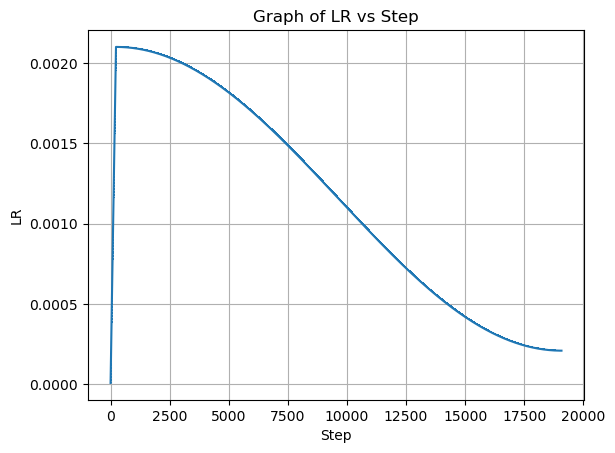

In [116]:
import matplotlib.pyplot as plt

lrs = [_compute_lr(step) for step in range(tot_steps)]
steps = list(range(len(lrs)))

plt.plot(steps, lrs, linestyle='-', marker=',')
plt.title("Graph of LR vs Step")
plt.xlabel("Step")
plt.ylabel("LR")
plt.grid(True)
plt.show()